# Random Forest

In [6]:
#@title Importando as Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import traceback # Para melhor debugging de exceções

In [7]:
#@title Funções auxiliares

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0) # Evitar divisão por zero no RSI
    return 100 - (100 / (1 + rs))

def add_technical_indicators(df):
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['STD_5'] = df['Close'].rolling(window=5).std()
    df['RSI'] = compute_rsi(df['Close'], 14)
    df['Close_Lag_1'] = df['Close'].shift(1)
    df['Close_Lag_2'] = df['Close'].shift(2)
    # Adicionar 'Volume' se disponível e desejado
    # Por exemplo, se a coluna 'Volume' existir no seu CSV:
    if 'Volume' in df.columns:
         df['Volume_SMA_5'] = df['Volume'].rolling(window=5).mean()
         df['Volume_Lag_1'] = df['Volume'].shift(1)
    return df

In [8]:
#@title Classe Agente Inteligente

class AgenteFlorestAvancado:
    def __init__(self, df_original, threshold=0.005, capital_inicial=10000):
        self.df_original = df_original.copy()
        self.threshold = threshold
        self.operacoes = []
        self.capital_inicial = capital_inicial
        self.capital_diario = []
        self.df_processed = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None]*4
        self.modelo = None
        self.y_pred_returns = None
        self.capital_final = None

        # Define as features base. Pode ser expandido.
        self.features = ['SMA_5', 'SMA_10', 'STD_5', 'RSI', 'Close_Lag_1', 'Close_Lag_2', 'Close']

        # Se você descomentou indicadores de volume em add_technical_indicators, adicione as features aqui:
        # Exemplo:
        if 'Volume' in self.df_original.columns and 'Volume_SMA_5' in add_technical_indicators(self.df_original.copy(deep=True)).columns: # Test run to check
             self.features.extend(['Volume_SMA_5', 'Volume_Lag_1'])


    def preparar_dados(self):
        self.df_processed = self.df_original.copy()

        # Verificar se a coluna 'Close' existe
        if 'Close' not in self.df_processed.columns:
            raise ValueError("A coluna 'Close' é obrigatória e não foi encontrada no DataFrame.")

        self.df_processed = add_technical_indicators(self.df_processed)

        self.df_processed['Target_Return'] = (self.df_processed['Close'].shift(-1) - self.df_processed['Close']) / self.df_processed['Close']

        self.df_processed.dropna(inplace=True)

        # Garante que todas as features definidas existem no df_processed
        for feature in self.features:
            if feature not in self.df_processed.columns:
                # Tenta remover a feature se ela não pôde ser criada (ex: 'Close' se todos os lags foram usados)
                # Ou lança um erro se for uma feature crítica
                if feature in self.features: # Para evitar erro se já removido
                    print(f"Atenção: Feature '{feature}' não encontrada no DataFrame processado. Removendo da lista de features.")
                    self.features.remove(feature)

        self.X = self.df_processed[self.features]
        self.y = self.df_processed['Target_Return']

        if self.X.empty or self.y.empty:
            raise ValueError("X ou y estão vazios após o pré-processamento. Verifique os dados, janelas dos indicadores e se há dados suficientes.")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, shuffle=False, test_size=0.2, random_state=42
        )
        print(f"Tamanho X_train: {self.X_train.shape}, X_test: {self.X_test.shape}")
        print(f"Tamanho y_train: {self.y_train.shape}, y_test: {self.y_test.shape}")


    def treinar_modelo(self):
        if self.X_train is None or self.y_train is None or self.X_train.empty:
            raise ValueError("Dados de treino não preparados. Execute preparar_dados() primeiro.")
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [2, 4, 8]
        }
        tscv = TimeSeriesSplit(n_splits=5) # 3 splits para rodar mais rápido, pode aumentar para 5

        grid = GridSearchCV(RandomForestRegressor(random_state=42),
                            param_grid,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            verbose=1)
        grid.fit(self.X_train, self.y_train)
        self.modelo = grid.best_estimator_
        print(f"Melhores parâmetros: {grid.best_params_}")
        self.y_pred_returns = self.modelo.predict(self.X_test)

    def avaliar_modelo(self):
        if self.y_test is None or self.y_pred_returns is None:
            print("Modelo não treinado ou dados de teste não disponíveis.")
            return
        mse = mean_squared_error(self.y_test, self.y_pred_returns)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test, self.y_pred_returns)
        r2 = r2_score(self.y_test, self.y_pred_returns)
        print("\nMétricas de avaliação sobre os RETORNOS:")
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    def simular_operacoes(self):
        if self.y_pred_returns is None or self.X_test is None or self.y_test is None:
            raise ValueError("Execute treinar_modelo() e preparar_dados() primeiro.")

        capital = self.capital_inicial
        posicao_em_acoes = 0
        valor_compra_acao = 0
        self.capital_diario = [self.capital_inicial] # Começa com o capital inicial
        self.operacoes = []

        # Precisamos dos preços de fechamento do dia 't+1' para operar.
        # O índice de X_test corresponde ao dia 't'.
        datas_operacao_t_mais_1 = []
        precos_reais_operacao_t_mais_1 = []

        for idx_t in self.X_test.index:
            try:
                loc_idx_t = self.df_original.index.get_loc(idx_t)
                if loc_idx_t + 1 < len(self.df_original.index):
                    idx_t_mais_1 = self.df_original.index[loc_idx_t + 1]
                    datas_operacao_t_mais_1.append(idx_t_mais_1)
                    precos_reais_operacao_t_mais_1.append(self.df_original.loc[idx_t_mais_1, 'Close'])
                else: # Não há dia t+1 para o último idx_t
                    break
            except KeyError: # Caso idx_t não seja encontrado, embora X_test.index venha de df_processed (que é de df_original)
                print(f"Aviso: Índice {idx_t} não encontrado em df_original. Pulando.")
                continue # Pula esta iteração se o índice não for encontrado

        num_operacoes_possiveis = len(precos_reais_operacao_t_mais_1)
        y_pred_local = self.y_pred_returns[:num_operacoes_possiveis]

        # Remove o capital inicial da lista, pois ele será o valor base para o primeiro dia *antes* de qualquer operação.
        # O capital diário deve refletir o valor da carteira *após* as decisões do dia.
        # Se o primeiro dia de X_test não tem um dia t+1, não haverá operações e capital_diario ficará vazio
        if num_operacoes_possiveis > 0:
            self.capital_diario = []
        else:
            self.capital_diario = [self.capital_inicial] # Se nenhuma operação possível, carteira é capital inicial.

        for i in range(num_operacoes_possiveis):
            retorno_previsto_t_para_t_mais_1 = y_pred_local[i]
            preco_real_op_t_mais_1 = precos_reais_operacao_t_mais_1[i]
            data_op = datas_operacao_t_mais_1[i]

            # Simulação de lógica de trading
            if posicao_em_acoes == 0:
                if retorno_previsto_t_para_t_mais_1 > self.threshold:
                    if preco_real_op_t_mais_1 > 0 and capital > 0:
                        posicao_em_acoes = capital / preco_real_op_t_mais_1
                        valor_compra_acao = preco_real_op_t_mais_1
                        capital = 0
                        self.operacoes.append((data_op, preco_real_op_t_mais_1, 'Compra'))
            elif posicao_em_acoes > 0:
                if retorno_previsto_t_para_t_mais_1 < -self.threshold or i == num_operacoes_possiveis - 1:
                    if preco_real_op_t_mais_1 > 0:
                        capital = posicao_em_acoes * preco_real_op_t_mais_1
                        lucro = (preco_real_op_t_mais_1 - valor_compra_acao) * posicao_em_acoes
                        posicao_em_acoes = 0
                        valor_compra_acao = 0
                        self.operacoes.append((data_op, preco_real_op_t_mais_1, 'Venda', lucro))

            # Atualizar capital diário
            if posicao_em_acoes > 0:
                self.capital_diario.append(posicao_em_acoes * preco_real_op_t_mais_1)
            else:
                self.capital_diario.append(capital)

        if self.capital_diario:
            self.capital_final = self.capital_diario[-1]
        else: # Se nenhuma operação foi possível ou nenhuma realizada
            self.capital_final = self.capital_inicial

        print(f"\n--- Resultados da Simulação (Threshold: {self.threshold*100:.2f}%) ---")
        print(f"Capital inicial: R${self.capital_inicial:.2f}")
        print(f"Capital final: R${self.capital_final:.2f}")
        lucro_total = self.capital_final - self.capital_inicial
        rentabilidade = (lucro_total / self.capital_inicial) * 100 if self.capital_inicial > 0 else 0
        print(f"Lucro/Prejuízo: R${lucro_total:.2f} ({rentabilidade:.2f}%)")
        print(f"Número de operações realizadas: {len(self.operacoes)}")


    def plotar_resultados(self):
        if self.y_test is None or self.y_pred_returns is None:
            print("Modelo não treinado ou dados de teste não disponíveis para plotagem.")
            return

        # Plot de Retornos Previstos vs Reais
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test.index, self.y_test.values, label='Retorno Real Diário', color='blue', alpha=0.7, linewidth=1)
        plt.plot(self.y_test.index, self.y_pred_returns[:len(self.y_test)], label='Retorno Previsto Diário (RF)', color='orange', linestyle='--', linewidth=1.5)
        plt.axhline(0, color='gray', linestyle=':', linewidth=0.8)
        plt.axhline(self.threshold, color='green', linestyle=':', linewidth=1, label=f'Threshold Compra ({self.threshold:.2%})')
        plt.axhline(-self.threshold, color='red', linestyle=':', linewidth=1, label=f'Threshold Venda ({-self.threshold:.2%})')
        plt.title("Previsão de Retornos Diários vs. Reais")
        plt.xlabel("Data (Dia 't' da Geração das Features)")
        plt.ylabel("Retorno Percentual")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Plot de Operações nos Preços Reais
        if not self.operacoes and not self.capital_diario: # Se não há o que plotar
            print("Nenhuma operação ou dado de capital para plotar gráfico de preços e operações.")
        else:
            # Determinar o range de datas para o plot dos preços
            # As datas das operações são em t+1
            datas_para_plot_precos = []
            if self.operacoes: # Se houve operações, usar as datas delas
                datas_para_plot_precos = sorted(list(set(op[0] for op in self.operacoes)))
            elif self.X_test is not None and not self.X_test.empty: # Senão, usar o período de teste t+1
                 for idx_t in self.X_test.index:
                    try:
                        loc_idx_t = self.df_original.index.get_loc(idx_t)
                        if loc_idx_t + 1 < len(self.df_original.index):
                           datas_para_plot_precos.append(self.df_original.index[loc_idx_t + 1])
                    except KeyError: continue

            if datas_para_plot_precos:
                min_date_plot = min(datas_para_plot_precos)
                max_date_plot = max(datas_para_plot_precos)
                precos_plot_df = self.df_original.loc[min_date_plot:max_date_plot, 'Close']

                plt.figure(figsize=(14, 7))
                plt.plot(precos_plot_df.index, precos_plot_df.values, label='Preço Real de Fechamento', color='black', alpha=0.6, linewidth=1)

                compras_datas = [op[0] for op in self.operacoes if op[2] == 'Compra']
                compras_precos = [op[1] for op in self.operacoes if op[2] == 'Compra']
                vendas_datas = [op[0] for op in self.operacoes if op[2] == 'Venda']
                vendas_precos = [op[1] for op in self.operacoes if op[2] == 'Venda']

                if compras_datas:
                    plt.scatter(compras_datas, compras_precos, color='green', label='Compra', marker='^', s=70, alpha=0.9, zorder=5, edgecolors='k', linewidth=0.5)
                if vendas_datas:
                    plt.scatter(vendas_datas, vendas_precos, color='red', label='Venda', marker='v', s=70, alpha=0.9, zorder=5, edgecolors='k', linewidth=0.5)

                plt.title("Operações de Compra e Venda Sobre Preços Reais")
                plt.xlabel("Data da Operação (Dia 't+1')")
                plt.ylabel("Preço de Operação")
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles)) # Para evitar legendas duplicadas
                plt.legend(by_label.values(), by_label.keys())
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            else:
                print("Não foi possível determinar o range de datas para o plot de operações e preços.")


        # Plot do Capital
        if self.capital_diario:
            # As datas para o capital_diario são as 'datas_operacao_t_mais_1'
            # que foram usadas para preencher o self.capital_diario
            datas_plot_capital = []
            num_dias_capital = len(self.capital_diario)

            # Reconstruir as datas para o eixo X do capital_diario
            # Elas correspondem às datas t+1 do período de teste
            count = 0
            for idx_t in self.X_test.index:
                if count >= num_dias_capital:
                    break
                try:
                    loc_idx_t = self.df_original.index.get_loc(idx_t)
                    if loc_idx_t + 1 < len(self.df_original.index):
                        datas_plot_capital.append(self.df_original.index[loc_idx_t + 1])
                        count += 1
                    else: # Se não há t+1, não deveria ter capital_diario para este ponto
                        pass
                except KeyError:
                    continue

            if datas_plot_capital and len(datas_plot_capital) == len(self.capital_diario):
                plt.figure(figsize=(12, 6))
                plt.plot(datas_plot_capital, self.capital_diario, label="Valor da Carteira", color='purple', linewidth=1.5)
                plt.title("Evolução do Capital na Simulação")
                plt.xlabel("Data da Avaliação da Carteira (Fim do Dia 't+1')")
                plt.ylabel("Capital (R$)")
                plt.axhline(self.capital_inicial, color='grey', linestyle='--', label=f'Capital Inicial (R${self.capital_inicial:.0f})')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Aviso: Não foi possível alinhar todas as datas para o plot do capital (datas encontradas: {len(datas_plot_capital)}, pontos de capital: {len(self.capital_diario)}). Plotando com índice numérico se houver dados.")
                if self.capital_diario: # Plotar mesmo assim se houver dados
                    plt.figure(figsize=(12, 6))
                    plt.plot(self.capital_diario, label="Valor da Carteira", color='purple')
                    plt.title("Evolução do Capital na Simulação (Índice Numérico)")
                    plt.xlabel("Período de Teste (Dias de Operação)")
                    plt.ylabel("Capital (R$)")
                    plt.axhline(self.capital_inicial, color='grey', linestyle='--', label=f'Capital Inicial (R${self.capital_inicial:.0f})')
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
        else:
            print("Não há dados de capital diário para plotar.")

    def calcular_benchmark_buy_and_hold(self):
        if self.X_test is None or self.X_test.empty:
            print("Dados de teste não disponíveis para calcular o benchmark.")
            return None, None, None

        try:
            # Data de início do período de teste (dia t)
            primeiro_dia_features_teste = self.X_test.index[0]
            # Data de fim do período de teste (dia t)
            ultimo_dia_features_teste = self.X_test.index[-1]

            # A estratégia Buy & Hold compraria no primeiro dia de operação possível (t+1)
            # e venderia no último dia de operação possível (t+1)

            # Encontrar o índice do primeiro dia t no df_original
            loc_primeiro_dia_t = self.df_original.index.get_loc(primeiro_dia_features_teste)
            if loc_primeiro_dia_t + 1 < len(self.df_original.index):
                data_inicio_bh = self.df_original.index[loc_primeiro_dia_t + 1]
                preco_inicial_bh = self.df_original.loc[data_inicio_bh, 'Close']
            else:
                print("Não foi possível determinar o preço inicial para o Buy and Hold (sem dia t+1 para o início).")
                return None, None, None

            # Encontrar o índice do último dia t no df_original
            loc_ultimo_dia_t = self.df_original.index.get_loc(ultimo_dia_features_teste)
            if loc_ultimo_dia_t + 1 < len(self.df_original.index):
                data_fim_bh = self.df_original.index[loc_ultimo_dia_t + 1]
                preco_final_bh = self.df_original.loc[data_fim_bh, 'Close']
            else:
                # Se não houver t+1 para o último dia de features,
                # usamos o preço do último dia de features como proxy.
                # Idealmente, a simulação e o B&H deveriam ter o mesmo último dia de "liquidação".
                # Se self.capital_diario foi populado, sua última data é a melhor referência
                if self.capital_diario and self.operacoes: # Se houve simulação e operações
                    # Tenta pegar a data da última operação da simulação
                    # Ou a última data para a qual o capital foi calculado
                    datas_capital_plot = []
                    count_dc = 0
                    for idx_t_dc in self.X_test.index:
                        if count_dc >= len(self.capital_diario): break
                        try:
                            loc_idx_t_dc = self.df_original.index.get_loc(idx_t_dc)
                            if loc_idx_t_dc + 1 < len(self.df_original.index):
                                datas_capital_plot.append(self.df_original.index[loc_idx_t_dc + 1])
                                count_dc += 1
                        except KeyError: continue

                    if datas_capital_plot:
                        data_fim_bh = datas_capital_plot[-1]
                        preco_final_bh = self.df_original.loc[data_fim_bh, 'Close']
                    else: # Fallback se não conseguir alinhar
                        print("Não foi possível determinar o preço final exato para o Buy and Hold alinhado com a simulação.")
                        return None, None, None
                else: # Se não houve simulação, ou está vazio
                     print("Não foi possível determinar o preço final para o Buy and Hold (sem dia t+1 para o fim ou sem dados de simulação).")
                     return None, None, None


            retorno_bh = ((preco_final_bh - preco_inicial_bh) / preco_inicial_bh) * 100

            print(f"\n--- Benchmark: Buy and Hold (Período de Teste: {data_inicio_bh.date()} a {data_fim_bh.date()}) ---")
            print(f"Preço Inicial S&P 500 ({data_inicio_bh.date()}): R${preco_inicial_bh:.2f}")
            print(f"Preço Final S&P 500 ({data_fim_bh.date()}): R${preco_final_bh:.2f}")
            print(f"Retorno Buy and Hold: {retorno_bh:.2f}%")

            # Você também pode calcular o valor final do capital inicial com Buy & Hold
            capital_final_bh = self.capital_inicial * (1 + (retorno_bh / 100))
            print(f"Capital Inicial com Buy and Hold: R${self.capital_inicial:.2f}")
            print(f"Capital Final com Buy and Hold: R${capital_final_bh:.2f}")

            return retorno_bh, preco_inicial_bh, preco_final_bh

        except Exception as e:
            print(f"Erro ao calcular o benchmark Buy and Hold: {e}")
            traceback.print_exc()
            return None, None, None

In [9]:
#@title Carregamento dos dados

# --- Exemplo de Uso ---
ARQUIVO_CSV = "SP500.csv" # Coloque o nome do seu arquivo CSV aqui

try:
    # Carregamento dos dados do CSV
    df = pd.read_csv(ARQUIVO_CSV, parse_dates=['Date'])
    # Verificar se a coluna 'Date' foi parseada corretamente
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        print(f"Aviso: A coluna 'Date' em {ARQUIVO_CSV} não foi parseada como data. Tentando converter...")
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        if df['Date'].isnull().any():
            raise ValueError(f"Falha ao converter a coluna 'Date' para datetime. Verifique o formato em {ARQUIVO_CSV}.")

    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

    # Verificar colunas essenciais
    if 'Close' not in df.columns:
        raise ValueError(f"Coluna 'Close' não encontrada em {ARQUIVO_CSV}.")
    # Opcional: Verificar 'Volume' se for usar indicadores de volume
    # if 'Volume' not in df.columns:
    #     print(f"Aviso: Coluna 'Volume' não encontrada em {ARQUIVO_CSV}. Indicadores de volume não serão usados.")

    print(f"Dados carregados de {ARQUIVO_CSV} com sucesso.")
    print(f"Período dos dados: de {df.index.min()} a {df.index.max()}")
    print(f"Número de registros: {len(df)}")

except FileNotFoundError:
    print(f"Arquivo '{ARQUIVO_CSV}' não encontrado. Usando dados fictícios para demonstração.")
    dates = pd.to_datetime(pd.date_range(start='2020-01-01', end='2023-12-31', freq='B'))
    data_size = len(dates)
    np.random.seed(42)
    base_price = 500
    drift = 0.0001
    volatility = 0.015
    returns_fict = np.random.normal(loc=drift, scale=volatility, size=data_size-1)
    price_data = [base_price]
    for r in returns_fict:
        price_data.append(price_data[-1] * (1 + r))
    price_data = np.array(price_data)
    price_data[price_data <= 0] = 1
    volume_data = np.random.randint(100000, 5000000, size=data_size)
    df = pd.DataFrame({'Date': dates, 'Close': price_data, 'Volume': volume_data})
    df.set_index('Date', inplace=True)
    print("Dados fictícios gerados.")

except ValueError as ve:
    print(f"Erro ao processar o arquivo CSV: {ve}")
    print("Não foi possível carregar ou processar os dados. O script não pode continuar sem dados válidos.")
    df = None # Define df como None para evitar execução posterior

Dados carregados de SP500.csv com sucesso.
Período dos dados: de 2010-01-04 00:00:00 a 2019-12-31 00:00:00
Número de registros: 2516


Tamanho X_train: (2004, 9), X_test: (502, 9)
Tamanho y_train: (2004,), y_test: (502,)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 200}

Métricas de avaliação sobre os RETORNOS:
RMSE: 0.0095, MAE: 0.0066, R²: -0.0151

--- Resultados da Simulação (Threshold: 0.50%) ---
Capital inicial: R$10000.00
Capital final: R$13092.27
Lucro/Prejuízo: R$3092.27 (30.92%)
Número de operações realizadas: 2

--- Benchmark: Buy and Hold (Período de Teste: 2018-01-03 a 2019-12-31) ---
Preço Inicial S&P 500 (2018-01-03): R$2713.06
Preço Final S&P 500 (2019-12-31): R$3230.78
Retorno Buy and Hold: 19.08%
Capital Inicial com Buy and Hold: R$10000.00
Capital Final com Buy and Hold: R$11908.25


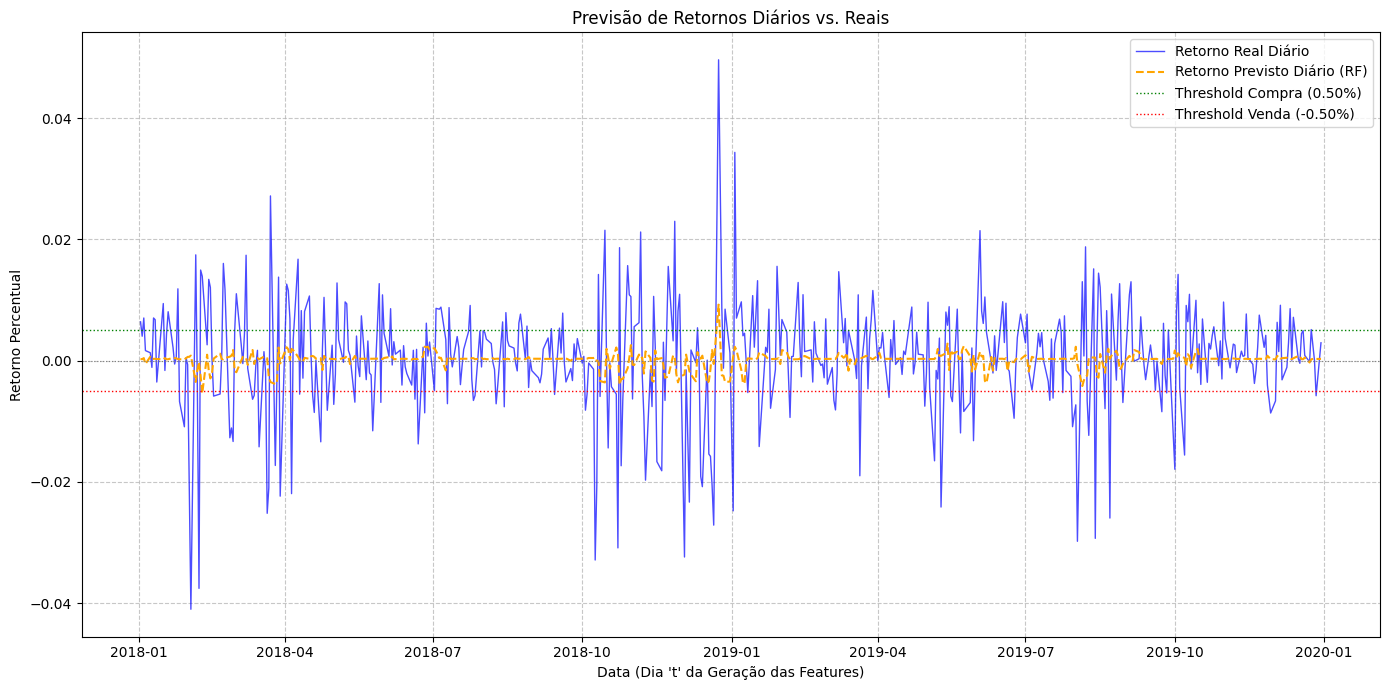

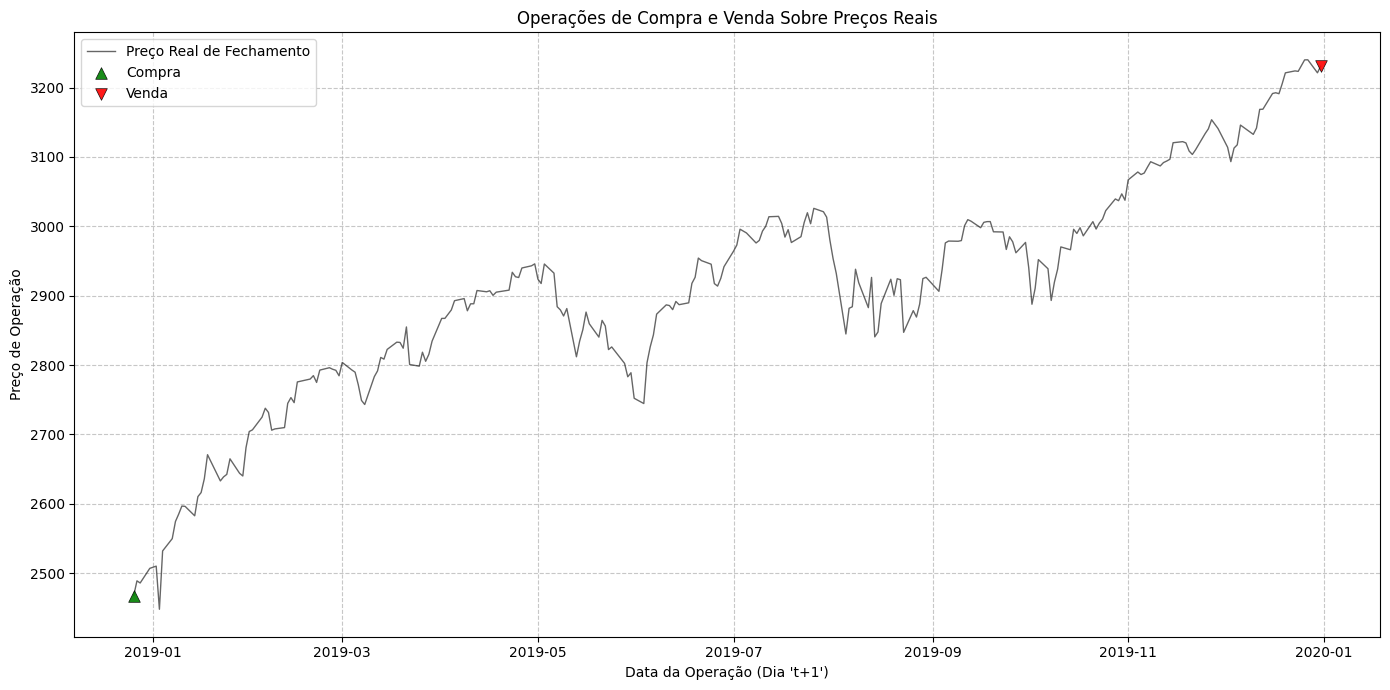

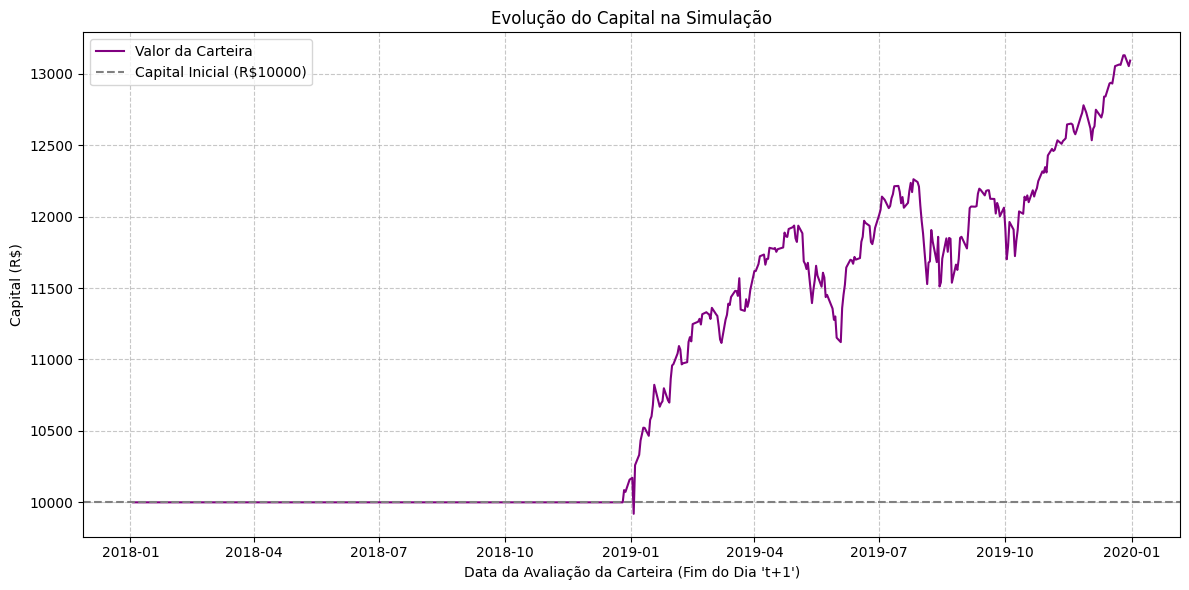

In [10]:
#@title Execução do Agente

if df is not None and not df.empty:
    # Execução do agente
    # Você pode ajustar o threshold e capital_inicial aqui se desejar
    # Ex: agente = AgenteFlorestAvancado(df, threshold=0.005, capital_inicial=50000)
    agente = AgenteFlorestAvancado(df) # Usa os padrões da classe (threshold=0.01, capital_inicial=10000)

    try:
        agente.preparar_dados()
        agente.treinar_modelo()
        agente.avaliar_modelo()
        agente.simular_operacoes()

        agente.calcular_benchmark_buy_and_hold()

        # O print do capital final já está dentro de simular_operacoes, mas pode ser repetido se desejar:
        # print(f"Capital final (verificação externa): R${agente.capital_final:.2f}")
        agente.plotar_resultados()
    except ValueError as e:
        print(f"Erro durante a execução do agente: {e}")
        traceback.print_exc()
    except Exception as e: # Captura outras exceções inesperadas
        print(f"Um erro inesperado ocorreu durante a execução do agente: {e}")
        traceback.print_exc()
else:
    print("Nenhum DataFrame válido para processar. Encerrando o script.")